In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import open3d as o3d
from PIL import Image as im
import math

#### Point cloud generation

In [ ]:
scene = "scene0005_01"

In [110]:
camera_intrinsics = np.loadtxt('./intrinsics/'+scene+'/intrinsic_depth.txt')
print(camera_intrinsics)
fx = camera_intrinsics[0][0]
fy = camera_intrinsics[1][1]
S = camera_intrinsics[0][1]
cx = camera_intrinsics[0][2]
cy = camera_intrinsics[1][2]

camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(width=640, height=480, fx=fx,fy=fy,cx=cx,cy=cy)

[[577.870605   0.       319.5        0.      ]
 [  0.       577.870605 239.5        0.      ]
 [  0.         0.         1.         0.      ]
 [  0.         0.         0.         1.      ]]


In [121]:
scans_list = os.listdir('./imgs/'+scene)
scans_list = list(map(lambda x: x.split('.')[0],scans_list))

pcd_list = []
cnt = 0
for i,scan in enumerate(scans_list):
    depth_map = o3d.geometry.Image(np.ascontiguousarray(np.load('./depths/'+scene+"/"+scan+'.npy')).astype(np.float32))
#     rgb_img = cv2.resize(cv2.imread('./imgs/'+scene+'/'+scan+'.png'),(640,480))
#     rgb_img = o3d.geometry.Image(rgb_img)
    mask = cv2.resize(cv2.imread('./masks/'+scene+'/'+scans_list[i]+'.png'),(640,480))
    floor_segmentation = o3d.geometry.Image(np.asarray(np.isin(mask, [5])*254,dtype=np.uint8))
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d.geometry.Image(floor_segmentation), o3d.geometry.Image(depth_map),convert_rgb_to_intensity=False)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
    pose = np.loadtxt('./poses/'+scene+'/'+scan+'.txt',dtype=np.float32)
    pcd = pcd.transform(pose)
    pcd_list.append(pcd.uniform_down_sample(10))



In [122]:
pcd_combined = o3d.geometry.PointCloud()
for point_id in range(len(pcd_list)):
        pcd_combined += pcd_list[point_id]
o3d.io.write_point_cloud("./pcds/"+scene+".pcd", pcd_combined)

True

In [123]:
pcd = o3d.io.read_point_cloud("pcds/"+scene+".pcd")
o3d.visualization.draw_geometries([pcd])

In [124]:
points = np.asarray(pcd.points)
colors = np.asarray(pcd.colors)

In [125]:
max_coordinates = np.max(points,axis=0)
min_coordinates = np.min(points,axis=0)
print(max_coordinates,min_coordinates)

[4.47904062 7.1749649  2.5144639 ] [-0.02283584  1.06313455 -0.09268279]


#### Occupancy map characteristics

In [126]:
mpixel = 0.05
padding = 50
bound = max(abs(max_coordinates[0]),abs(min_coordinates[0]),abs(max_coordinates[1]),abs(min_coordinates[1]))
W = 2*math.ceil(bound/mpixel) + padding

In [127]:
OCCUPIED = np.array([0,0,0],dtype=np.float64) 
FREE = np.array([254,254,254],dtype=np.float64) 

In [132]:
p = np.copy(points)
col = p[:,0]/mpixel + W/2
row = W/2 - p[:,1]/mpixel 
idx = row.astype(int)*W+col.astype(int)
valid_idx = p[:,2]<1.5
p = p[valid_idx]
idx = idx[valid_idx]
c = (colors[valid_idx,0]*255).astype(int)
# print(np.sum(c==254))
rank = np.argsort(idx)
p = p[rank]
c = c[rank]
idx = idx[rank]
keep = np.ones_like(idx).astype(int)
keep[:-1] = idx[1:]!=idx[:-1]
occ = np.cumsum(c==0)[keep==1]
occ[1:] = occ[1:]-occ[:-1]
ground = np.logical_and(c==254,p[:,2]<0.2)
free = np.cumsum(ground)[keep==1]
free[1:] = free[1:]-free[:-1]
idx = idx[keep==1]
occupancy_grid = np.zeros((W*W),dtype=np.float64)
occupancy_grid[idx] = (occ/(occ+free+1e-6) > 0.5)+1
occupancy_grid = occupancy_grid.reshape((W,W))

In [86]:
print(occupancy_grid.shape)

(338, 338)


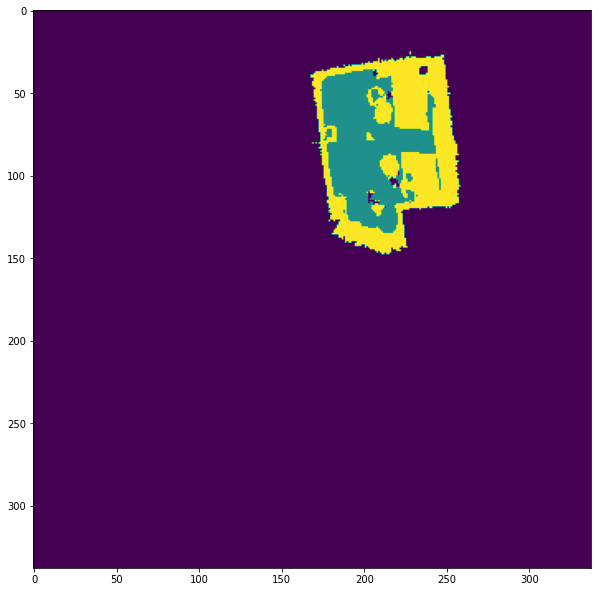

In [133]:
plt.figure(figsize=(10,15))
plt.imshow(np.asarray(occupancy_grid,dtype=np.uint8))

In [ ]:
properties = {
    "bounds":{
        "max_x":max_coordinates[0],
        "max_y":max_coordinates[1],
        "max_z":max_coordinates[2],
    }
}

# max, min, padding , resolution , downsampling , height thresholds 